In [203]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import datetime as dt
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
from lightgbm import early_stopping, log_evaluation

In [ ]:
df = pd.read_csv('flow_and_occupancy_data.csv')

,libelle,flow rate,occupancy rate,trafic state,tempC,windspeedKmph,winddirDegree,precipMM,humidity,visibility,...,HeatIndexC,DewPointC,WindChillC,WindGustKmph,FeelsLikeC,uvIndex,totalSnow_cm,school_holiday,public_holiday,time
0,0,704.0,11.40389,0,12.0,17.0,193.0,0.0,89.0,10.0,...,12.0,10.0,10.0,26.0,10.0,1.0,0.0,1.0,1.0,2023-11-01 04:00:00
1,0,547.0,6.10722,0,12.0,18.0,188.0,0.0,87.0,10.0,...,12.0,10.0,10.0,27.0,10.0,1.0,0.0,1.0,1.0,2023-11-01 05:00:00
2,0,635.0,14.22223,0,12.0,19.0,182.0,0.0,84.0,10.0,...,12.0,9.0,10.0,28.0,10.0,3.0,0.0,1.0,1.0,2023-11-01 06:00:00
3,0,899.0,27.25778,2,12.0,19.0,174.0,0.0,81.0,10.0,...,12.0,9.0,10.0,28.0,10.0,3.0,0.0,1.0,1.0,2023-11-01 07:00:00
4,0,515.0,6.83000,0,13.0,21.0,170.0,0.0,77.0,10.0,...,13.0,8.0,10.0,31.0,10.0,3.0,0.0,1.0,1.0,2023-11-01 08:00:00


In [12]:
df['time'].max()

'2024-12-06 00:00:00'

In [13]:
df['time'].min()

'2023-11-01 04:00:00'

In [ ]:
# Create new time features
df['date'] = pd.to_datetime(df['time'])
df['day_of_week'] = df['date'].dt.dayofweek
df['hour'] = df['date'].dt.hour
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)

# Create lag features
for lag in range(1, 8):
    df[f'flow_rate_lag_{lag}'] = df['flow rate'].shift(lag)
    df[f'occupancy_rate_lag_{lag}'] = df['occupancy rate'].shift(lag)

In [ ]:
# split data
df_train = df[(df['time']>='2023-11-01 04:00:00') & ((df['time']<'2024-10-06 00:00:00')) ]
df_val = df[(df['time']>='2024-10-06 00:00:00') & ((df['time']<'2024-12-01 00:00:00')) ]
df_test = df[(df['time']>='2024-12-01 00:00:00')]

In [122]:
y_train = df_train[['flow rate', 'occupancy rate']]

In [123]:
x_train = df_train.drop(columns=['flow rate', 'occupancy rate', 'time', 'date'])

In [163]:
y_test = df_test[['flow rate', 'occupancy rate']]

In [162]:
x_test = df_test.drop(columns=['flow rate', 'occupancy rate', 'time', 'date'])

In [126]:
y_val = df_val[['flow rate', 'occupancy rate']]

In [127]:
x_val = df_val.drop(columns=['flow rate', 'occupancy rate', 'time', 'date'])

In [128]:
x_train.columns

Index(['libelle', 'trafic state', 'tempC', 'windspeedKmph', 'winddirDegree',
       'precipMM', 'humidity', 'visibility', 'pressure', 'cloudcover',
       'HeatIndexC', 'DewPointC', 'WindChillC', 'WindGustKmph', 'FeelsLikeC',
       'uvIndex', 'totalSnow_cm', 'school_holiday', 'public_holiday',
       'day_of_week', 'hour', 'is_weekend', 'flow_rate_lag_1',
       'occupancy_rate_lag_1', 'flow_rate_lag_2', 'occupancy_rate_lag_2',
       'flow_rate_lag_3', 'occupancy_rate_lag_3', 'flow_rate_lag_4',
       'occupancy_rate_lag_4', 'flow_rate_lag_5', 'occupancy_rate_lag_5',
       'flow_rate_lag_6', 'occupancy_rate_lag_6', 'flow_rate_lag_7',
       'occupancy_rate_lag_7'],
      dtype='object')

Optuna for hyper parameters tuning :

LightGBM for predicting flow rate

In [170]:
# Define objective function for Optuna
def objective(trial):
    # Suggest hyperparameters for LightGBM
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 500),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.5),
        "max_depth": trial.suggest_int("max_depth", 3, 20),
        "num_leaves": trial.suggest_int("num_leaves", 20, 150),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 50),
        "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
        "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-8, 10.0),
        "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-8, 10.0),
    }

    # Train LightGBM model
    model = lgb.LGBMRegressor(**params, random_state=42)
    model.fit(x_train, y_train['flow rate'], eval_set=[(x_val, y_val['flow rate'])], eval_metric="rmse",  callbacks=[early_stopping(stopping_rounds=50), log_evaluation(0)])

    # Predict and evaluate RMSE
    y_pred = model.predict(x_val)
    rmse = np.sqrt(mean_squared_error(y_val['flow rate'], y_pred))
    return rmse

# Run Optuna optimization
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

# Best parameters
print("Best hyperparameters:", study.best_params)


[I 2024-12-06 17:08:41,294] A new study created in memory with name: no-name-c1854ceb-690c-46cc-aec9-75c026cea60f
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\3014502577.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.5),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\3014502577.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\3014502577.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003898 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4484
[LightGBM] [Info] Number of data points in the train set: 21476, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 362.569939
Training until validation scores don't improve for 50 rounds


[I 2024-12-06 17:08:41,819] Trial 0 finished with value: 64.09569928145336 and parameters: {'n_estimators': 372, 'learning_rate': 0.0414054039177221, 'max_depth': 15, 'num_leaves': 45, 'min_child_samples': 27, 'subsample': 0.7712796286350282, 'colsample_bytree': 0.9719759596827489, 'reg_alpha': 1.981534877331847e-08, 'reg_lambda': 0.030998521400003646}. Best is trial 0 with value: 64.09569928145336.


Early stopping, best iteration is:
[86]	valid_0's rmse: 64.0957	valid_0's l2: 4108.26
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003604 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4484
[LightGBM] [Info] Number of data points in the train set: 21476, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 362.569939
Training until validation scores don't improve for 50 rounds


C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\3014502577.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.5),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\3014502577.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\3014502577.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
C:\Users\

Early stopping, best iteration is:
[237]	valid_0's rmse: 62.1562	valid_0's l2: 3863.39
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003101 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4484
[LightGBM] [Info] Number of data points in the train set: 21476, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 362.569939
Training until validation scores don't improve for 50 rounds


C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\3014502577.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.5),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\3014502577.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\3014502577.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
C:\Users\

Early stopping, best iteration is:
[60]	valid_0's rmse: 63.0299	valid_0's l2: 3972.77
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003081 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4484
[LightGBM] [Info] Number of data points in the train set: 21476, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 362.569939
Training until validation scores don't improve for 50 rounds


C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\3014502577.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.5),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\3014502577.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\3014502577.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
C:\Users\

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-06 17:08:45,246] Trial 3 finished with value: 64.63798428841217 and parameters: {'n_estimators': 431, 'learning_rate': 0.14114166991219687, 'max_depth': 12, 'num_leaves': 129, 'min_child_samples': 42, 'subsample': 0.5456966608424205, 'colsample_bytree': 0.8599359375971216, 'reg_alpha': 2.89990331486384, 'reg_lambda': 0.002451707033500494}. Best is trial 1 with value: 62.156157195898274.
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\3014502577.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.5),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\3014502577.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004069 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4484
[LightGBM] [Info] Number of data points in the train set: 21476, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 362.569939
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2024-12-06 17:08:46,789] Trial 4 finished with value: 63.670354511972924 and parameters: {'n_estimators': 292, 'learning_rate': 0.028091106225655946, 'max_depth': 11, 'num_leaves': 101, 'min_child_samples': 45, 'subsample': 0.7448830082178044, 'colsample_bytree': 0.8978829538417634, 'reg_alpha': 5.389625591824671e-08, 'reg_lambda': 0.03688582383873292}. Best is trial 1 with value: 62.156157195898274.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[151]	valid_0's rmse: 63.6704	valid_0's l2: 4053.91
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003134 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4484
[LightGBM] [Info] Number of data points in the train set: 21476, number of used features: 36
[LightGBM] [Warning

C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\3014502577.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.5),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\3014502577.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\3014502577.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
C:\Users\

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[88]	valid_0's rmse: 62.9968	valid_0's l2: 3968.59
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003224 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4484
[LightGBM] [Info] Number of data points in the train set: 21476, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 362.569939
Training until validation scores don't improve for 50 rounds


C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\3014502577.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.5),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\3014502577.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\3014502577.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
C:\Users\

Early stopping, best iteration is:
[93]	valid_0's rmse: 64.0574	valid_0's l2: 4103.34
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002811 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4484
[LightGBM] [Info] Number of data points in the train set: 21476, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 362.569939
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\3014502577.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.5),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\3014502577.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\3014502577.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
C:\Users\

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003678 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4484
[LightGBM] [Info] Number of data points in the train set: 21476, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 362.569939
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2024-12-06 17:08:49,454] Trial 8 finished with value: 63.36763374432368 and parameters: {'n_estimators': 212, 'learning_rate': 0.1434452501535327, 'max_depth': 13, 'num_leaves': 139, 'min_child_samples': 20, 'subsample': 0.5585143169951454, 'colsample_bytree': 0.9411130463305954, 'reg_alpha': 0.00048605631065557983, 'reg_lambda': 1.8118445738323927e-07}. Best is trial 1 with value: 62.156157195898274.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[27]	valid_0's rmse: 63.3676	valid_0's l2: 4015.46
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing wa

C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\3014502577.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.5),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\3014502577.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\3014502577.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
C:\Users\

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-06 17:08:50,463] Trial 9 finished with value: 63.52619431784343 and parameters: {'n_estimators': 281, 'learning_rate': 0.09368586428558903, 'max_depth': 11, 'num_leaves': 56, 'min_child_samples': 29, 'subsample': 0.7794274665181447, 'colsample_bytree': 0.7751022213090397, 'reg_alpha': 0.7219881517536286, 'reg_lambda': 3.3718730351733906e-06}. Best is trial 1 with value: 62.156157195898274.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[275]	valid_0's rmse: 63.5262	valid_0's l2: 4035.58


C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\3014502577.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.5),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\3014502577.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\3014502577.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
C:\Users\

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002925 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4484
[LightGBM] [Info] Number of data points in the train set: 21476, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 362.569939
Training until validation scores don't improve for 50 rounds


[I 2024-12-06 17:08:50,946] Trial 10 finished with value: 169.44745688943263 and parameters: {'n_estimators': 64, 'learning_rate': 0.010019497685399007, 'max_depth': 20, 'num_leaves': 106, 'min_child_samples': 5, 'subsample': 0.6537314201132949, 'colsample_bytree': 0.500615538390752, 'reg_alpha': 2.4744701554024017e-06, 'reg_lambda': 1.7600703335331034e-08}. Best is trial 1 with value: 62.156157195898274.


Did not meet early stopping. Best iteration is:
[64]	valid_0's rmse: 169.447	valid_0's l2: 28712.4
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005101 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4484
[LightGBM] [Info] Number of data points in the train set: 21476, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 362.569939
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\3014502577.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.5),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\3014502577.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\3014502577.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
C:\Users\

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\3014502577.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.5),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\3014502577.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\3014502577.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
C:\Users\

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002242 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4484
[LightGBM] [Info] Number of data points in the train set: 21476, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 362.569939
Training until validation scores don't improve for 50 rounds


[I 2024-12-06 17:08:53,235] Trial 12 finished with value: 62.453287036614 and parameters: {'n_estimators': 357, 'learning_rate': 0.019509503894659393, 'max_depth': 19, 'num_leaves': 119, 'min_child_samples': 15, 'subsample': 0.6776703969343885, 'colsample_bytree': 0.6672023874955546, 'reg_alpha': 9.425473036833806e-07, 'reg_lambda': 2.954709094193028e-06}. Best is trial 1 with value: 62.156157195898274.


Early stopping, best iteration is:
[181]	valid_0's rmse: 62.4533	valid_0's l2: 3900.41
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004844 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4484
[LightGBM] [Info] Number of data points in the train set: 21476, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 362.569939
Training until validation scores don't improve for 50 rounds


C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\3014502577.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.5),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\3014502577.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\3014502577.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
C:\Users\

Early stopping, best iteration is:
[206]	valid_0's rmse: 62.1676	valid_0's l2: 3864.81
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003139 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4484
[LightGBM] [Info] Number of data points in the train set: 21476, number of used features: 36


C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\3014502577.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.5),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\3014502577.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\3014502577.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
C:\Users\

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 362.569939
Training until validation scores don't improve for 50 rounds


[I 2024-12-06 17:08:57,048] Trial 14 finished with value: 62.1350068883732 and parameters: {'n_estimators': 494, 'learning_rate': 0.011112778210750783, 'max_depth': 8, 'num_leaves': 82, 'min_child_samples': 5, 'subsample': 0.6992186456307236, 'colsample_bytree': 0.5972368131309655, 'reg_alpha': 2.9373546892251125e-05, 'reg_lambda': 1.1628396641940461e-06}. Best is trial 14 with value: 62.1350068883732.


Early stopping, best iteration is:
[320]	valid_0's rmse: 62.135	valid_0's l2: 3860.76
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002864 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4484
[LightGBM] [Info] Number of data points in the train set: 21476, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 362.569939
Training until validation scores don't improve for 50 rounds


C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\3014502577.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.5),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\3014502577.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\3014502577.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
C:\Users\

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[380]	valid_0's rmse: 62.4096	valid_0's l2: 3894.95


[I 2024-12-06 17:08:59,053] Trial 15 finished with value: 62.40955588658223 and parameters: {'n_estimators': 487, 'learning_rate': 0.01061620018104948, 'max_depth': 8, 'num_leaves': 81, 'min_child_samples': 5, 'subsample': 0.8580824591462939, 'colsample_bytree': 0.5811369819666778, 'reg_alpha': 2.9738030720974656e-05, 'reg_lambda': 1.8744532834559335e-08}. Best is trial 14 with value: 62.1350068883732.
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\3014502577.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.5),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\3014502577.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float ins

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002807 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4484
[LightGBM] [Info] Number of data points in the train set: 21476, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 362.569939
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2024-12-06 17:08:59,942] Trial 16 finished with value: 62.78198270650818 and parameters: {'n_estimators': 487, 'learning_rate': 0.025283623535406866, 'max_depth': 7, 'num_leaves': 93, 'min_child_samples': 10, 'subsample': 0.7248790167213323, 'colsample_bytree': 0.593926797114218, 'reg_alpha': 0.014954827278443519, 'reg_lambda': 5.305802695948828e-07}. Best is trial 14 with value: 62.1350068883732.
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\3014502577.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.5),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\3014502577.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float inste

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003162 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4484
[LightGBM] [Info] Number of data points in the train set: 21476, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 362.569939
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2024-12-06 17:09:00,243] Trial 17 finished with value: 64.49088381731252 and parameters: {'n_estimators': 426, 'learning_rate': 0.3355088312240836, 'max_depth': 9, 'num_leaves': 71, 'min_child_samples': 19, 'subsample': 0.5014096187699018, 'colsample_bytree': 0.7249243332546597, 'reg_alpha': 4.888173006381607e-05, 'reg_lambda': 1.0489144105385093e-07}. Best is trial 14 with value: 62.1350068883732.
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\3014502577.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.5),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\3014502577.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float inst

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002499 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4484
[LightGBM] [Info] Number of data points in the train set: 21476, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 362.569939
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2024-12-06 17:09:00,582] Trial 18 finished with value: 69.71325649175715 and parameters: {'n_estimators': 188, 'learning_rate': 0.014366632829850307, 'max_depth': 3, 'num_leaves': 70, 'min_child_samples': 9, 'subsample': 0.6310468658134365, 'colsample_bytree': 0.5180789182056845, 'reg_alpha': 2.3852159276501453e-07, 'reg_lambda': 4.081069730381119e-05}. Best is trial 14 with value: 62.1350068883732.
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\3014502577.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.5),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\3014502577.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float ins

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005228 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4484
[LightGBM] [Info] Number of data points in the train set: 21476, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 362.569939
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2024-12-06 17:09:00,903] Trial 19 finished with value: 64.91296144694851 and parameters: {'n_estimators': 151, 'learning_rate': 0.06665280524243684, 'max_depth': 5, 'num_leaves': 95, 'min_child_samples': 18, 'subsample': 0.8287210933343927, 'colsample_bytree': 0.7012006908963613, 'reg_alpha': 3.4949308163300854e-05, 'reg_lambda': 1.4770023017454154e-05}. Best is trial 14 with value: 62.1350068883732.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[54]	valid_0's rmse: 64.913	valid_0's l2: 4213.69
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003021 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4484
[LightGBM] [Info] Number of data points in the train set: 21476, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 362.569939
Training until validation scores don

C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\3014502577.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.5),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\3014502577.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\3014502577.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
C:\Users\

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[147]	valid_0's rmse: 62.5795	valid_0's l2: 3916.2


C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\3014502577.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.5),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\3014502577.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\3014502577.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
C:\Users\

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003107 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4484
[LightGBM] [Info] Number of data points in the train set: 21476, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 362.569939
Training until validation scores don't improve for 50 rounds


[I 2024-12-06 17:09:04,519] Trial 21 finished with value: 62.35278172971774 and parameters: {'n_estimators': 383, 'learning_rate': 0.01472728794282863, 'max_depth': 18, 'num_leaves': 114, 'min_child_samples': 15, 'subsample': 0.6897765422411702, 'colsample_bytree': 0.6198059893946742, 'reg_alpha': 2.461471269034696e-07, 'reg_lambda': 1.4899095147386482e-06}. Best is trial 14 with value: 62.1350068883732.


Early stopping, best iteration is:
[229]	valid_0's rmse: 62.3528	valid_0's l2: 3887.87
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003199 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4484
[LightGBM] [Info] Number of data points in the train set: 21476, number of used features: 36


C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\3014502577.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.5),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\3014502577.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\3014502577.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
C:\Users\

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 362.569939
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

[I 2024-12-06 17:09:05,539] Trial 22 finished with value: 63.05243164741166 and parameters: {'n_estimators': 335, 'learning_rate': 0.010090512215286956, 'max_depth': 6, 'num_leaves': 103, 'min_child_samples': 13, 'subsample': 0.6961782591343059, 'colsample_bytree': 0.6331810567411738, 'reg_alpha': 1.2178930944042201e-05, 'reg_lambda': 9.430500551591397}. Best is trial 14 with value: 62.1350068883732.
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\3014502577.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.5),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\3014502577.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float inste

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001833 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4484
[LightGBM] [Info] Number of data points in the train set: 21476, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 362.569939
Training until validation scores don't improve for 50 rounds


[I 2024-12-06 17:09:07,142] Trial 23 finished with value: 62.63153309217428 and parameters: {'n_estimators': 469, 'learning_rate': 0.01858187900961413, 'max_depth': 9, 'num_leaves': 113, 'min_child_samples': 5, 'subsample': 0.61674089316239, 'colsample_bytree': 0.7036172205366087, 'reg_alpha': 0.00023864223706091724, 'reg_lambda': 7.486186622953719e-06}. Best is trial 14 with value: 62.1350068883732.


Early stopping, best iteration is:
[194]	valid_0's rmse: 62.6315	valid_0's l2: 3922.71
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002206 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4484
[LightGBM] [Info] Number of data points in the train set: 21476, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 362.569939
Training until validation scores don't improve for 50 rounds


C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\3014502577.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.5),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\3014502577.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\3014502577.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
C:\Users\

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-06 17:09:08,352] Trial 24 finished with value: 63.13560372139957 and parameters: {'n_estimators': 236, 'learning_rate': 0.030250229007032448, 'max_depth': 13, 'num_leaves': 150, 'min_child_samples': 23, 'subsample': 0.796576873580231, 'colsample_bytree': 0.552700789027127, 'reg_alpha': 2.63213365792457e-07, 'reg_lambda': 2.5979560311161684e-07}. Best is trial 14 with value: 62.1350068883732.
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\3014502577.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.5),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\3014502577.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float ins

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002997 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4484
[LightGBM] [Info] Number of data points in the train set: 21476, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 362.569939
Training until validation scores don't improve for 50 rounds


[I 2024-12-06 17:09:10,022] Trial 25 finished with value: 62.22481141896684 and parameters: {'n_estimators': 400, 'learning_rate': 0.01399428202382805, 'max_depth': 17, 'num_leaves': 89, 'min_child_samples': 16, 'subsample': 0.9843331536875325, 'colsample_bytree': 0.6119487521948938, 'reg_alpha': 6.121769448189359e-06, 'reg_lambda': 6.852568901076322e-08}. Best is trial 14 with value: 62.1350068883732.


Early stopping, best iteration is:
[274]	valid_0's rmse: 62.2248	valid_0's l2: 3871.93
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003076 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4484
[LightGBM] [Info] Number of data points in the train set: 21476, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 362.569939
Training until validation scores don't improve for 50 rounds


C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\3014502577.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.5),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\3014502577.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\3014502577.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
C:\Users\

Early stopping, best iteration is:
[181]	valid_0's rmse: 62.8876	valid_0's l2: 3954.85
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002672 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4484
[LightGBM] [Info] Number of data points in the train set: 21476, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 362.569939
Training until validation scores don't improve for 50 rounds


C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\3014502577.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.5),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\3014502577.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\3014502577.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
C:\Users\

Did not meet early stopping. Best iteration is:
[296]	valid_0's rmse: 63.3459	valid_0's l2: 4012.7


C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\3014502577.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.5),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\3014502577.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\3014502577.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
C:\Users\

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003183 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4484
[LightGBM] [Info] Number of data points in the train set: 21476, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 362.569939
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2024-12-06 17:09:13,449] Trial 28 finished with value: 63.1332207001579 and parameters: {'n_estimators': 354, 'learning_rate': 0.05450082994737449, 'max_depth': 8, 'num_leaves': 123, 'min_child_samples': 50, 'subsample': 0.861745824040914, 'colsample_bytree': 0.7423960220645438, 'reg_alpha': 0.0002035706759481914, 'reg_lambda': 4.234970682875246e-08}. Best is trial 14 with value: 62.1350068883732.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[75]	valid_0's rmse: 63.1332	valid_0's l2: 3985.8
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005114 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4484
[LightGBM] [Info] Number of data points in the train set: 21476, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 362.569939
Training until validation scores don

C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\3014502577.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.5),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\3014502577.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\3014502577.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
C:\Users\

Early stopping, best iteration is:
[111]	valid_0's rmse: 64.415	valid_0's l2: 4149.29
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003111 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4484
[LightGBM] [Info] Number of data points in the train set: 21476, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 362.569939
Training until validation scores don't improve for 50 rounds


C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\3014502577.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.5),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\3014502577.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\3014502577.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
C:\Users\

Early stopping, best iteration is:
[169]	valid_0's rmse: 62.6036	valid_0's l2: 3919.21
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003111 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4484
[LightGBM] [Info] Number of data points in the train set: 21476, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 362.569939
Training until validation scores don't improve for 50 rounds


C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\3014502577.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.5),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\3014502577.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\3014502577.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
C:\Users\

Early stopping, best iteration is:
[255]	valid_0's rmse: 62.1378	valid_0's l2: 3861.1
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002740 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4484
[LightGBM] [Info] Number of data points in the train set: 21476, number of used features: 36


C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\3014502577.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.5),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\3014502577.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\3014502577.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
C:\Users\

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 362.569939
Training until validation scores don't improve for 50 rounds


[I 2024-12-06 17:09:18,328] Trial 32 finished with value: 62.961449408295294 and parameters: {'n_estimators': 374, 'learning_rate': 0.01674931188279703, 'max_depth': 20, 'num_leaves': 62, 'min_child_samples': 7, 'subsample': 0.9832896476768072, 'colsample_bytree': 0.5901103402550932, 'reg_alpha': 7.1625345530136126e-06, 'reg_lambda': 2.937611236057759e-07}. Best is trial 14 with value: 62.1350068883732.


Early stopping, best iteration is:
[216]	valid_0's rmse: 62.9614	valid_0's l2: 3964.14
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002826 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4484
[LightGBM] [Info] Number of data points in the train set: 21476, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 362.569939
Training until validation scores don't improve for 50 rounds


C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\3014502577.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.5),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\3014502577.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\3014502577.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
C:\Users\

Early stopping, best iteration is:
[268]	valid_0's rmse: 62.823	valid_0's l2: 3946.72
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004137 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4484
[LightGBM] [Info] Number of data points in the train set: 21476, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 362.569939
Training until validation scores don't improve for 50 rounds


C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\3014502577.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.5),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\3014502577.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\3014502577.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
C:\Users\

Did not meet early stopping. Best iteration is:
[307]	valid_0's rmse: 63.0641	valid_0's l2: 3977.08
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002674 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4484
[LightGBM] [Info] Number of data points in the train set: 21476, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 362.569939
Training until validation scores don't improve for 50 rounds


C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\3014502577.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.5),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\3014502577.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\3014502577.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
C:\Users\

Early stopping, best iteration is:
[158]	valid_0's rmse: 63.2398	valid_0's l2: 3999.27
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003164 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4484
[LightGBM] [Info] Number of data points in the train set: 21476, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 362.569939
Training until validation scores don't improve for 50 rounds


C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\3014502577.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.5),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\3014502577.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\3014502577.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
C:\Users\

Early stopping, best iteration is:
[48]	valid_0's rmse: 63.8497	valid_0's l2: 4076.79
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002633 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4484
[LightGBM] [Info] Number of data points in the train set: 21476, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 362.569939
Training until validation scores don't improve for 50 rounds


[I 2024-12-06 17:09:24,769] Trial 37 finished with value: 62.191877966073605 and parameters: {'n_estimators': 337, 'learning_rate': 0.011830134072060693, 'max_depth': 12, 'num_leaves': 77, 'min_child_samples': 20, 'subsample': 0.5840075635402489, 'colsample_bytree': 0.6410495601282133, 'reg_alpha': 2.605402193906506e-06, 'reg_lambda': 5.719586820016429e-08}. Best is trial 14 with value: 62.1350068883732.


Did not meet early stopping. Best iteration is:
[316]	valid_0's rmse: 62.1919	valid_0's l2: 3867.83


C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\3014502577.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.5),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\3014502577.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\3014502577.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
C:\Users\

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003077 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4484
[LightGBM] [Info] Number of data points in the train set: 21476, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 362.569939
Training until validation scores don't improve for 50 rounds


[I 2024-12-06 17:09:25,753] Trial 38 finished with value: 62.44269564669648 and parameters: {'n_estimators': 459, 'learning_rate': 0.03221121486105699, 'max_depth': 19, 'num_leaves': 98, 'min_child_samples': 10, 'subsample': 0.9332058835950452, 'colsample_bytree': 0.7277251113537999, 'reg_alpha': 0.0032658843913835234, 'reg_lambda': 2.8258440763135333e-05}. Best is trial 14 with value: 62.1350068883732.


Early stopping, best iteration is:
[106]	valid_0's rmse: 62.4427	valid_0's l2: 3899.09
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003018 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4484
[LightGBM] [Info] Number of data points in the train set: 21476, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 362.569939
Training until validation scores don't improve for 50 rounds


C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\3014502577.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.5),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\3014502577.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\3014502577.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
C:\Users\

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-06 17:09:26,368] Trial 39 finished with value: 65.44916715504128 and parameters: {'n_estimators': 297, 'learning_rate': 0.19268840701469328, 'max_depth': 11, 'num_leaves': 107, 'min_child_samples': 21, 'subsample': 0.5876772516433257, 'colsample_bytree': 0.6038218116532245, 'reg_alpha': 1.2569741939687426e-08, 'reg_lambda': 0.00018506915733714686}. Best is trial 14 with value: 62.1350068883732.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\3014502577.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.5),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\3014502577.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\3014502577.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
C:\Users\

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003139 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4484
[LightGBM] [Info] Number of data points in the train set: 21476, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 362.569939
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2024-12-06 17:09:28,842] Trial 40 finished with value: 63.02922463942101 and parameters: {'n_estimators': 494, 'learning_rate': 0.016525603282414588, 'max_depth': 14, 'num_leaves': 132, 'min_child_samples': 26, 'subsample': 0.7958688212522572, 'colsample_bytree': 0.8943726109182274, 'reg_alpha': 3.992444422778859e-07, 'reg_lambda': 1.8615120208463678e-07}. Best is trial 14 with value: 62.1350068883732.
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\3014502577.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.5),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\3014502577.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float 

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003094 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4484
[LightGBM] [Info] Number of data points in the train set: 21476, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 362.569939
Training until validation scores don't improve for 50 rounds


[I 2024-12-06 17:09:30,429] Trial 41 finished with value: 62.29525803897726 and parameters: {'n_estimators': 337, 'learning_rate': 0.011678401061228985, 'max_depth': 12, 'num_leaves': 76, 'min_child_samples': 21, 'subsample': 0.5164914418056343, 'colsample_bytree': 0.6411962963383994, 'reg_alpha': 2.724038026290982e-06, 'reg_lambda': 5.6383652140439147e-08}. Best is trial 14 with value: 62.1350068883732.


Did not meet early stopping. Best iteration is:
[302]	valid_0's rmse: 62.2953	valid_0's l2: 3880.7


C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\3014502577.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.5),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\3014502577.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\3014502577.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
C:\Users\

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002967 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4484
[LightGBM] [Info] Number of data points in the train set: 21476, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 362.569939
Training until validation scores don't improve for 50 rounds


[I 2024-12-06 17:09:31,870] Trial 42 finished with value: 62.079624397580474 and parameters: {'n_estimators': 384, 'learning_rate': 0.012206375005043874, 'max_depth': 10, 'num_leaves': 61, 'min_child_samples': 17, 'subsample': 0.5924664180862593, 'colsample_bytree': 0.6483217503231524, 'reg_alpha': 3.4642140327644e-06, 'reg_lambda': 3.77891047948825e-08}. Best is trial 42 with value: 62.079624397580474.


Early stopping, best iteration is:
[312]	valid_0's rmse: 62.0796	valid_0's l2: 3853.88
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003327 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4484
[LightGBM] [Info] Number of data points in the train set: 21476, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 362.569939
Training until validation scores don't improve for 50 rounds


C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\3014502577.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.5),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\3014502577.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\3014502577.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
C:\Users\

Early stopping, best iteration is:
[212]	valid_0's rmse: 62.5832	valid_0's l2: 3916.65
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003119 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4484
[LightGBM] [Info] Number of data points in the train set: 21476, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 362.569939
Training until validation scores don't improve for 50 rounds


C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\3014502577.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.5),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\3014502577.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\3014502577.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
C:\Users\

Early stopping, best iteration is:
[169]	valid_0's rmse: 63.2826	valid_0's l2: 4004.69
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002775 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4484
[LightGBM] [Info] Number of data points in the train set: 21476, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 362.569939
Training until validation scores don't improve for 50 rounds


C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\3014502577.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.5),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\3014502577.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\3014502577.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
C:\Users\

Did not meet early stopping. Best iteration is:
[274]	valid_0's rmse: 63.5162	valid_0's l2: 4034.31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003140 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4484
[LightGBM] [Info] Number of data points in the train set: 21476, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 362.569939
Training until validation scores don't improve for 50 rounds


C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\3014502577.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.5),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\3014502577.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\3014502577.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
C:\Users\

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[309]	valid_0's rmse: 62.7096	valid_0's l2: 3932.49


[I 2024-12-06 17:09:36,153] Trial 46 finished with value: 62.70955092167013 and parameters: {'n_estimators': 364, 'learning_rate': 0.013550504230396597, 'max_depth': 7, 'num_leaves': 52, 'min_child_samples': 6, 'subsample': 0.6346173296042047, 'colsample_bytree': 0.6486916821218267, 'reg_alpha': 0.0006390552849836074, 'reg_lambda': 2.265715603333776e-06}. Best is trial 42 with value: 62.079624397580474.
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\3014502577.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.5),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\3014502577.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float in

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003189 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4484
[LightGBM] [Info] Number of data points in the train set: 21476, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 362.569939
Training until validation scores don't improve for 50 rounds


[I 2024-12-06 17:09:37,084] Trial 47 finished with value: 62.12833154389375 and parameters: {'n_estimators': 464, 'learning_rate': 0.027867362402989194, 'max_depth': 8, 'num_leaves': 91, 'min_child_samples': 14, 'subsample': 0.603334088405733, 'colsample_bytree': 0.7062888975245761, 'reg_alpha': 1.4235372010260951e-06, 'reg_lambda': 6.718393289526596e-06}. Best is trial 42 with value: 62.079624397580474.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\3014502577.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.5),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\3014502577.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\3014502577.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
C:\Users\

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001917 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4484
[LightGBM] [Info] Number of data points in the train set: 21476, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 362.569939
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2024-12-06 17:09:38,001] Trial 48 finished with value: 62.67259492066853 and parameters: {'n_estimators': 464, 'learning_rate': 0.04106776941372161, 'max_depth': 8, 'num_leaves': 91, 'min_child_samples': 7, 'subsample': 0.6009693458136804, 'colsample_bytree': 0.7684752109399345, 'reg_alpha': 5.88461608874169e-06, 'reg_lambda': 4.83677418994111e-06}. Best is trial 42 with value: 62.079624397580474.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[105]	valid_0's rmse: 62.6726	valid_0's l2: 3927.85
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003301 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4484
[LightGBM] [Info] Number of data points in the train set: 21476, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 362.569939
[LightGBM] [Warning] No further sp

C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\3014502577.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.5),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\3014502577.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\3014502577.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
C:\Users\

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-06 17:09:38,763] Trial 49 finished with value: 62.687199557957214 and parameters: {'n_estimators': 415, 'learning_rate': 0.028749345686408776, 'max_depth': 6, 'num_leaves': 81, 'min_child_samples': 38, 'subsample': 0.5735906081220581, 'colsample_bytree': 0.6993577177426691, 'reg_alpha': 6.108155088491106e-07, 'reg_lambda': 8.487505422723976e-07}. Best is trial 42 with value: 62.079624397580474.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [171]:
# Best parameters
print("Best hyperparameters:", study.best_params)

Best hyperparameters: {'n_estimators': 384, 'learning_rate': 0.012206375005043874, 'max_depth': 10, 'num_leaves': 61, 'min_child_samples': 17, 'subsample': 0.5924664180862593, 'colsample_bytree': 0.6483217503231524, 'reg_alpha': 3.4642140327644e-06, 'reg_lambda': 3.77891047948825e-08}


In [172]:
best_hyper_2 = study.best_params

In [173]:
# Train final LightGBM model with best hyperparameters
best_params = best_hyper_2
final_model = lgb.LGBMRegressor(**best_params, random_state=42)
final_model.fit(x_train, y_train['flow rate'])

# Final evaluation
y_pred_2 = final_model.predict(x_test)
final_rmse = np.sqrt(mean_squared_error(y_test['flow rate'], y_pred_2))
print(f"Final RMSE: {final_rmse:.2f}")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003493 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4484
[LightGBM] [Info] Number of data points in the train set: 21476, number of used features: 36
[LightGBM] [Info] Start training from score 362.569939
Final RMSE: 66.74


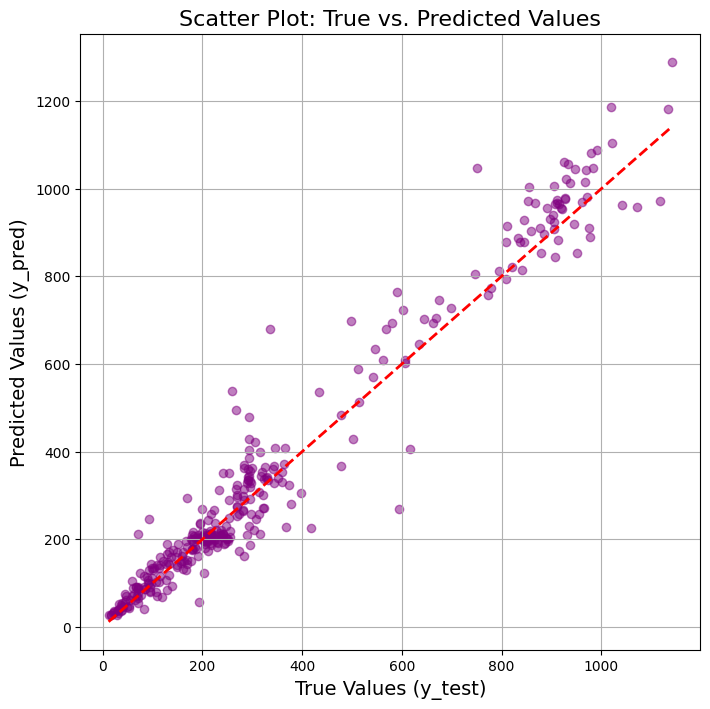

In [176]:
plt.figure(figsize=(8, 8))
plt.scatter(y_test['flow rate'], y_pred_2, alpha=0.5, color="purple")
plt.plot([y_test['flow rate'].min(), y_test['flow rate'].max()], [y_test['flow rate'].min(), y_test['flow rate'].max()], "r--", lw=2)  # Perfect prediction line
plt.title("Scatter Plot: True vs. Predicted Values", fontsize=16)
plt.xlabel("True Values (y_test)", fontsize=14)
plt.ylabel("Predicted Values (y_pred)", fontsize=14)
plt.grid(True)
plt.show()

LightGBM for predicting Occupancy rate

In [158]:
# Define objective function for Optuna
def objective(trial):
    # Suggest hyperparameters for LightGBM
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 500),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.5),
        "max_depth": trial.suggest_int("max_depth", 3, 20),
        "num_leaves": trial.suggest_int("num_leaves", 20, 150),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 50),
        "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
        "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-8, 10.0),
        "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-8, 10.0),
    }

    # Train LightGBM model
    model = lgb.LGBMRegressor(**params, random_state=42)
    model.fit(x_train, y_train['occupancy rate'], eval_set=[(x_val, y_val['occupancy rate'])], eval_metric="rmse",  callbacks=[early_stopping(stopping_rounds=50), log_evaluation(0)])

    # Predict and evaluate RMSE
    y_pred = model.predict(x_val)
    rmse = np.sqrt(mean_squared_error(y_val['occupancy rate'], y_pred))
    return rmse

# Run Optuna optimization
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

# Best parameters
print("Best hyperparameters:", study.best_params)

[I 2024-12-06 17:03:53,512] A new study created in memory with name: no-name-48df11cc-9424-4a62-ac32-29cda4112c0b
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\537831899.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.5),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\537831899.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\537831899.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. 

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003288 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4484
[LightGBM] [Info] Number of data points in the train set: 21476, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 8.938099
Training until validation scores don't improve for 50 rounds


[I 2024-12-06 17:03:53,904] Trial 0 finished with value: 2.1024797563431163 and parameters: {'n_estimators': 255, 'learning_rate': 0.1671006422547201, 'max_depth': 12, 'num_leaves': 68, 'min_child_samples': 11, 'subsample': 0.7890750452728813, 'colsample_bytree': 0.7818641482797063, 'reg_alpha': 2.514619840579846e-05, 'reg_lambda': 7.11177274532589e-06}. Best is trial 0 with value: 2.1024797563431163.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[39]	valid_0's rmse: 2.10248	valid_0's l2: 4.42042
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003150 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4484
[LightGBM] [Info] Number of data points in the train set: 21476, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 8.938099
Training until validation scores don't improve for 50 rounds


C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\537831899.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.5),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\537831899.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\537831899.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
C:\Users\aya

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-06 17:03:54,367] Trial 1 finished with value: 2.130498150987835 and parameters: {'n_estimators': 338, 'learning_rate': 0.27331683841993004, 'max_depth': 18, 'num_leaves': 118, 'min_child_samples': 27, 'subsample': 0.6300121455081202, 'colsample_bytree': 0.9765675848056938, 'reg_alpha': 2.7455475054124146e-07, 'reg_lambda': 1.0888870709333125e-06}. Best is trial 0 with value: 2.1024797563431163.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[13]	valid_0's rmse: 2.1305	valid_0's l2: 4.53902
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003035 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4484
[LightGBM] [Info] Number of data points in the train set: 21476, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 8.938099
Training until validation scores don't improve for 50 rounds


C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\537831899.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.5),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\537831899.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\537831899.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
C:\Users\aya

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-06 17:03:55,187] Trial 2 finished with value: 2.0918057522239417 and parameters: {'n_estimators': 295, 'learning_rate': 0.06476553650663905, 'max_depth': 10, 'num_leaves': 119, 'min_child_samples': 36, 'subsample': 0.5976539648189502, 'colsample_bytree': 0.8518379180533915, 'reg_alpha': 4.120311310133881, 'reg_lambda': 9.578353428005261e-05}. Best is trial 2 with value: 2.0918057522239417.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\537831899.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.5),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\537831899.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\537831899.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
C:\Users\aya

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004345 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4484
[LightGBM] [Info] Number of data points in the train set: 21476, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 8.938099
Training until validation scores don't improve for 50 rounds


[I 2024-12-06 17:03:55,441] Trial 3 finished with value: 3.5140198281365826 and parameters: {'n_estimators': 63, 'learning_rate': 0.014291176754266242, 'max_depth': 20, 'num_leaves': 24, 'min_child_samples': 23, 'subsample': 0.9462822200238116, 'colsample_bytree': 0.8264472592294995, 'reg_alpha': 0.04636236387399049, 'reg_lambda': 7.254892150223917e-07}. Best is trial 2 with value: 2.0918057522239417.


Did not meet early stopping. Best iteration is:
[63]	valid_0's rmse: 3.51402	valid_0's l2: 12.3483
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003061 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4484
[LightGBM] [Info] Number of data points in the train set: 21476, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 8.938099
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\537831899.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.5),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\537831899.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\537831899.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
C:\Users\aya

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-06 17:03:56,193] Trial 4 finished with value: 2.074104590686338 and parameters: {'n_estimators': 177, 'learning_rate': 0.03143363643145498, 'max_depth': 7, 'num_leaves': 94, 'min_child_samples': 32, 'subsample': 0.5474941222309582, 'colsample_bytree': 0.774400046914269, 'reg_alpha': 8.292937101152855e-08, 'reg_lambda': 1.3851657620682644e-08}. Best is trial 4 with value: 2.074104590686338.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\537831899.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.5),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\537831899.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\537831899.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
C:\Users\aya

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002918 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4484
[LightGBM] [Info] Number of data points in the train set: 21476, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 8.938099
Training until validation scores don't improve for 50 rounds


[I 2024-12-06 17:03:58,193] Trial 5 finished with value: 2.0905045097864363 and parameters: {'n_estimators': 438, 'learning_rate': 0.02213974051093977, 'max_depth': 19, 'num_leaves': 110, 'min_child_samples': 39, 'subsample': 0.9128519299789819, 'colsample_bytree': 0.9888958557675558, 'reg_alpha': 1.2969217848836796, 'reg_lambda': 8.943879318047718e-08}. Best is trial 4 with value: 2.074104590686338.


Early stopping, best iteration is:
[182]	valid_0's rmse: 2.0905	valid_0's l2: 4.37021
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002263 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4484
[LightGBM] [Info] Number of data points in the train set: 21476, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 8.938099
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\537831899.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.5),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\537831899.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\537831899.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
C:\Users\aya

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\537831899.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.5),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\537831899.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\537831899.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
C:\Users\aya

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003624 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4484
[LightGBM] [Info] Number of data points in the train set: 21476, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 8.938099
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

[I 2024-12-06 17:03:59,191] Trial 8 finished with value: 2.069372434401365 and parameters: {'n_estimators': 63, 'learning_rate': 0.0866542665728764, 'max_depth': 14, 'num_leaves': 139, 'min_child_samples': 34, 'subsample': 0.9507766425814204, 'colsample_bytree': 0.7431553251759636, 'reg_alpha': 8.572046976705147e-05, 'reg_lambda': 2.287511378352773}. Best is trial 8 with value: 2.069372434401365.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 2.06937	valid_0's l2: 4.2823
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002901 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4484
[LightGBM] [Info] Number of data points in the train set: 21476, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[Li

C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\537831899.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.5),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\537831899.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\537831899.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
C:\Users\aya

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\537831899.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.5),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\537831899.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\537831899.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
C:\Users\aya

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003299 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4484
[LightGBM] [Info] Number of data points in the train set: 21476, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 8.938099
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

[I 2024-12-06 17:04:00,143] Trial 10 finished with value: 2.0820833100161042 and parameters: {'n_estimators': 144, 'learning_rate': 0.0908008082142601, 'max_depth': 14, 'num_leaves': 145, 'min_child_samples': 44, 'subsample': 0.8403672983795087, 'colsample_bytree': 0.6655598874009011, 'reg_alpha': 0.0002437220476887146, 'reg_lambda': 5.5811261529355}. Best is trial 8 with value: 2.069372434401365.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\537831899.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.5),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\537831899.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\537831899.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
C:\Users\aya

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003018 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4484
[LightGBM] [Info] Number of data points in the train set: 21476, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 8.938099
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

[I 2024-12-06 17:04:00,864] Trial 11 finished with value: 2.0682866846905226 and parameters: {'n_estimators': 141, 'learning_rate': 0.036830820269468004, 'max_depth': 7, 'num_leaves': 80, 'min_child_samples': 34, 'subsample': 0.6620456132877037, 'colsample_bytree': 0.7116662071779452, 'reg_alpha': 4.311387443011862e-08, 'reg_lambda': 0.04958099567743339}. Best is trial 11 with value: 2.0682866846905226.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\537831899.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.5),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\537831899.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\537831899.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
C:\Users\aya

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002972 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4484
[LightGBM] [Info] Number of data points in the train set: 21476, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 8.938099
Training until validation scores don't improve for 50 rounds


[I 2024-12-06 17:04:01,477] Trial 12 finished with value: 2.060091056343294 and parameters: {'n_estimators': 131, 'learning_rate': 0.05405577809003652, 'max_depth': 9, 'num_leaves': 63, 'min_child_samples': 31, 'subsample': 0.6727463222473649, 'colsample_bytree': 0.6368859697623941, 'reg_alpha': 6.387679336361875e-06, 'reg_lambda': 0.198503545810399}. Best is trial 12 with value: 2.060091056343294.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\537831899.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.5),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\537831899.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\537831899.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
C:\Users\aya

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000884 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4484
[LightGBM] [Info] Number of data points in the train set: 21476, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 8.938099
Training until validation scores don't improve for 50 rounds


[I 2024-12-06 17:04:02,146] Trial 13 finished with value: 2.057930222115112 and parameters: {'n_estimators': 160, 'learning_rate': 0.04238887344528697, 'max_depth': 9, 'num_leaves': 48, 'min_child_samples': 23, 'subsample': 0.6828928815272736, 'colsample_bytree': 0.5193781178200879, 'reg_alpha': 1.077027099453371e-08, 'reg_lambda': 0.04134437988056003}. Best is trial 13 with value: 2.057930222115112.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[158]	valid_0's rmse: 2.05793	valid_0's l2: 4.23508
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead

C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\537831899.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.5),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\537831899.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\537831899.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
C:\Users\aya

Training until validation scores don't improve for 50 rounds


[I 2024-12-06 17:04:02,649] Trial 14 finished with value: 2.061129941334019 and parameters: {'n_estimators': 195, 'learning_rate': 0.05131653741382996, 'max_depth': 10, 'num_leaves': 39, 'min_child_samples': 21, 'subsample': 0.6840920798498638, 'colsample_bytree': 0.5021950616664911, 'reg_alpha': 1.5022295767484958e-06, 'reg_lambda': 0.08677691965221057}. Best is trial 13 with value: 2.057930222115112.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[194]	valid_0's rmse: 2.06113	valid_0's l2: 4.24826


C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\537831899.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.5),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\537831899.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\537831899.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
C:\Users\aya

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003214 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4484
[LightGBM] [Info] Number of data points in the train set: 21476, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 8.938099
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-12-06 17:04:03,148] Trial 15 finished with value: 2.103143605983483 and parameters: {'n_estimators': 122, 'learning_rate': 0.13274550425237716, 'max_depth': 9, 'num_leaves': 49, 'min_child_samples': 17, 'subsample': 0.7039201811931662, 'colsample_bytree': 0.6065252445153512, 'reg_alpha': 1.0435705482165796e-08, 'reg_lambda': 0.002548705649984393}. Best is trial 13 with value: 2.057930222115112.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[95]	valid_0's rmse: 2.10314	valid_0's l2: 4.42321
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001915 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4484
[LightGBM] [Info] Number of data points in the train set: 21476, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 8.938099
Training until validation scores don't improve for 50 rounds


C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\537831899.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.5),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\537831899.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\537831899.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
C:\Users\aya

Did not meet early stopping. Best iteration is:
[321]	valid_0's rmse: 2.15261	valid_0's l2: 4.63375
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001637 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4484
[LightGBM] [Info] Number of data points in the train set: 21476, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 8.938099
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\537831899.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.5),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\537831899.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\537831899.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
C:\Users\aya

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-06 17:04:04,500] Trial 17 finished with value: 2.1288848796774102 and parameters: {'n_estimators': 498, 'learning_rate': 0.0233408955507716, 'max_depth': 4, 'num_leaves': 47, 'min_child_samples': 15, 'subsample': 0.7280049245922013, 'colsample_bytree': 0.5072719794628315, 'reg_alpha': 0.0026445607893823206, 'reg_lambda': 0.0016630217285661197}. Best is trial 13 with value: 2.057930222115112.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[498]	valid_0's rmse: 2.12888	valid_0's l2: 4.53215
[LightGBM] [Warning] Found whitespace in feature_names, replace with underl

C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\537831899.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.5),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\537831899.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\537831899.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
C:\Users\aya

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-06 17:04:05,073] Trial 18 finished with value: 2.101870252519352 and parameters: {'n_estimators': 239, 'learning_rate': 0.13058785978495518, 'max_depth': 8, 'num_leaves': 66, 'min_child_samples': 24, 'subsample': 0.5888164858335829, 'colsample_bytree': 0.6267368620785564, 'reg_alpha': 6.97649468415745e-07, 'reg_lambda': 0.8306810097061343}. Best is trial 13 with value: 2.057930222115112.
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\537831899.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.5),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\537831899.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003594 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4484
[LightGBM] [Info] Number of data points in the train set: 21476, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 8.938099
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\537831899.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.5),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\537831899.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\537831899.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
C:\Users\aya

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003273 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4484
[LightGBM] [Info] Number of data points in the train set: 21476, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 8.938099
Training until validation scores don't improve for 50 rounds


[I 2024-12-06 17:04:05,968] Trial 20 finished with value: 2.1177222238840905 and parameters: {'n_estimators': 186, 'learning_rate': 0.01816678039949181, 'max_depth': 14, 'num_leaves': 34, 'min_child_samples': 41, 'subsample': 0.8089386619934722, 'colsample_bytree': 0.5543643455471647, 'reg_alpha': 1.9462784454108192e-05, 'reg_lambda': 0.34718564407464864}. Best is trial 13 with value: 2.057930222115112.


Did not meet early stopping. Best iteration is:
[186]	valid_0's rmse: 2.11772	valid_0's l2: 4.48475
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002660 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4484
[LightGBM] [Info] Number of data points in the train set: 21476, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 8.938099
Training until validation scores don't improve for 50 rounds


C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\537831899.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.5),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\537831899.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\537831899.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
C:\Users\aya

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[198]	valid_0's rmse: 2.05677	valid_0's l2: 4.23032


C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\537831899.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.5),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\537831899.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\537831899.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
C:\Users\aya

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003044 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4484
[LightGBM] [Info] Number of data points in the train set: 21476, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 8.938099
Training until validation scores don't improve for 50 rounds


[I 2024-12-06 17:04:07,261] Trial 22 finished with value: 2.0638229636220538 and parameters: {'n_estimators': 170, 'learning_rate': 0.03477443195674148, 'max_depth': 11, 'num_leaves': 55, 'min_child_samples': 20, 'subsample': 0.7234586200975784, 'colsample_bytree': 0.5362944177326356, 'reg_alpha': 3.6320236312637257e-07, 'reg_lambda': 0.018044582818552014}. Best is trial 21 with value: 2.056774580413536.


Did not meet early stopping. Best iteration is:
[169]	valid_0's rmse: 2.06382	valid_0's l2: 4.25937
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003194 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4484
[LightGBM] [Info] Number of data points in the train set: 21476, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 8.938099
Training until validation scores don't improve for 50 rounds


C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\537831899.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.5),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\537831899.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\537831899.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
C:\Users\aya

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[99]	valid_0's rmse: 2.08776	valid_0's l2: 4.35872
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001799 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4484
[LightGBM] [Info] Number of data points in the train set: 21476, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 8.938099
Training until validation scores don't improve for 50 rounds


C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\537831899.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.5),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\537831899.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\537831899.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
C:\Users\aya

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-06 17:04:08,482] Trial 24 finished with value: 2.0576158551072177 and parameters: {'n_estimators': 211, 'learning_rate': 0.07389667151092989, 'max_depth': 10, 'num_leaves': 73, 'min_child_samples': 15, 'subsample': 0.7577051077594649, 'colsample_bytree': 0.588635071164765, 'reg_alpha': 1.8355139136803926e-06, 'reg_lambda': 0.00039195602269123127}. Best is trial 21 with value: 2.056774580413536.
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\537831899.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.5),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\537831899.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float in

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002676 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4484
[LightGBM] [Info] Number of data points in the train set: 21476, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 8.938099
Training until validation scores don't improve for 50 rounds


[I 2024-12-06 17:04:09,144] Trial 25 finished with value: 2.074800083236516 and parameters: {'n_estimators': 215, 'learning_rate': 0.086671923637735, 'max_depth': 13, 'num_leaves': 77, 'min_child_samples': 13, 'subsample': 0.7604778466675018, 'colsample_bytree': 0.5746778933007957, 'reg_alpha': 0.0019410611880514488, 'reg_lambda': 0.0005871970607882228}. Best is trial 21 with value: 2.056774580413536.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[82]	valid_0's rmse: 2.0748	valid_0's l2: 4.3048


C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\537831899.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.5),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\537831899.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\537831899.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
C:\Users\aya

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003558 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4484
[LightGBM] [Info] Number of data points in the train set: 21476, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 8.938099
Training until validation scores don't improve for 50 rounds


[I 2024-12-06 17:04:10,127] Trial 26 finished with value: 2.0702473611290837 and parameters: {'n_estimators': 271, 'learning_rate': 0.028618063327480344, 'max_depth': 11, 'num_leaves': 55, 'min_child_samples': 6, 'subsample': 0.8747474883463898, 'colsample_bytree': 0.5127799395488107, 'reg_alpha': 9.593148773905067e-07, 'reg_lambda': 8.476999383904741e-05}. Best is trial 21 with value: 2.056774580413536.


Did not meet early stopping. Best iteration is:
[260]	valid_0's rmse: 2.07025	valid_0's l2: 4.28592
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002895 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4484
[LightGBM] [Info] Number of data points in the train set: 21476, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 8.938099
Training until validation scores don't improve for 50 rounds


C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\537831899.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.5),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\537831899.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\537831899.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
C:\Users\aya

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-06 17:04:11,308] Trial 27 finished with value: 2.0534520999299186 and parameters: {'n_estimators': 342, 'learning_rate': 0.04073264475056984, 'max_depth': 10, 'num_leaves': 72, 'min_child_samples': 12, 'subsample': 0.7443189651350325, 'colsample_bytree': 0.5957566620516784, 'reg_alpha': 3.566319237805861e-08, 'reg_lambda': 0.010147839417439382}. Best is trial 27 with value: 2.0534520999299186.


Early stopping, best iteration is:
[227]	valid_0's rmse: 2.05345	valid_0's l2: 4.21667
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003062 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4484
[LightGBM] [Info] Number of data points in the train set: 21476, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 8.938099
Training until validation scores don't improve for 50 rounds


C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\537831899.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.5),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\537831899.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\537831899.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
C:\Users\aya

Early stopping, best iteration is:
[93]	valid_0's rmse: 2.07121	valid_0's l2: 4.2899
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4484
[LightGBM] [Info] Number of data points in the train set: 21476, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 8.938099
Training until validation scores don't improve for 50 rounds


C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\537831899.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.5),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\537831899.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\537831899.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
C:\Users\aya

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[50]	valid_0's rmse: 2.10257	valid_0's l2: 4.42082
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002636 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4484
[LightGBM] [Info] Number of data points in the train set: 21476, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 8.938099
Training until validation scores don't improve for 50 rounds


C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\537831899.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.5),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\537831899.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\537831899.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
C:\Users\aya

Early stopping, best iteration is:
[55]	valid_0's rmse: 2.10598	valid_0's l2: 4.43517
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002796 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4484
[LightGBM] [Info] Number of data points in the train set: 21476, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 8.938099
Training until validation scores don't improve for 50 rounds


C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\537831899.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.5),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\537831899.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\537831899.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
C:\Users\aya

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-06 17:04:14,488] Trial 31 finished with value: 2.0575695283538473 and parameters: {'n_estimators': 214, 'learning_rate': 0.04042632838055797, 'max_depth': 9, 'num_leaves': 55, 'min_child_samples': 18, 'subsample': 0.7591547970223746, 'colsample_bytree': 0.5382824629109644, 'reg_alpha': 2.546426722003025e-08, 'reg_lambda': 0.03405559848365211}. Best is trial 27 with value: 2.0534520999299186.
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\537831899.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.5),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\537831899.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float inste

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003513 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4484
[LightGBM] [Info] Number of data points in the train set: 21476, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 8.938099
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

[I 2024-12-06 17:04:15,282] Trial 32 finished with value: 2.0582010792567846 and parameters: {'n_estimators': 357, 'learning_rate': 0.06875989756842543, 'max_depth': 7, 'num_leaves': 55, 'min_child_samples': 18, 'subsample': 0.7735590980776279, 'colsample_bytree': 0.5388969556105596, 'reg_alpha': 3.1746440990933084e-07, 'reg_lambda': 0.0058544125151016434}. Best is trial 27 with value: 2.0534520999299186.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[193]	valid_0's rmse: 2.0582	valid_0's l2: 4.23619
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001805 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4484
[LightGBM] [Info] Number of data points in the train set: 21476, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Inf

C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\537831899.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.5),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\537831899.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\537831899.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
C:\Users\aya

Did not meet early stopping. Best iteration is:
[209]	valid_0's rmse: 2.09107	valid_0's l2: 4.37258
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002752 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4484
[LightGBM] [Info] Number of data points in the train set: 21476, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 8.938099
Training until validation scores don't improve for 50 rounds


C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\537831899.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.5),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\537831899.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\537831899.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
C:\Users\aya

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-12-06 17:04:17,160] Trial 34 finished with value: 2.066674384822865 and parameters: {'n_estimators': 309, 'learning_rate': 0.04151086552312014, 'max_depth': 12, 'num_leaves': 89, 'min_child_samples': 10, 'subsample': 0.7075890418195228, 'colsample_bytree': 0.5374020305110344, 'reg_alpha': 3.6604257184595366e-08, 'reg_lambda': 0.02656280697959305}. Best is trial 27 with value: 2.0534520999299186.


Early stopping, best iteration is:
[171]	valid_0's rmse: 2.06667	valid_0's l2: 4.27114
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003007 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4484
[LightGBM] [Info] Number of data points in the train set: 21476, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 8.938099
Training until validation scores don't improve for 50 rounds


C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\537831899.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.5),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\537831899.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\537831899.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
C:\Users\aya

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-06 17:04:17,650] Trial 35 finished with value: 2.0974689551850543 and parameters: {'n_estimators': 263, 'learning_rate': 0.10218440056347293, 'max_depth': 8, 'num_leaves': 72, 'min_child_samples': 15, 'subsample': 0.7441831276363697, 'colsample_bytree': 0.6294495559159777, 'reg_alpha': 1.9354167582204435e-07, 'reg_lambda': 0.00016023871014847745}. Best is trial 27 with value: 2.0534520999299186.
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\537831899.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.5),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\537831899.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float i

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002878 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4484
[LightGBM] [Info] Number of data points in the train set: 21476, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 8.938099
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

[I 2024-12-06 17:04:18,499] Trial 36 finished with value: 2.073357240687174 and parameters: {'n_estimators': 379, 'learning_rate': 0.06327061520953396, 'max_depth': 6, 'num_leaves': 59, 'min_child_samples': 20, 'subsample': 0.8707260786221909, 'colsample_bytree': 0.724440656661379, 'reg_alpha': 4.7136759567029775e-08, 'reg_lambda': 0.08977966634406066}. Best is trial 27 with value: 2.0534520999299186.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\537831899.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.5),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\537831899.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\537831899.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
C:\Users\aya

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-06 17:04:20,392] Trial 37 finished with value: 2.0772813293055123 and parameters: {'n_estimators': 240, 'learning_rate': 0.021147082953742184, 'max_depth': 11, 'num_leaves': 105, 'min_child_samples': 25, 'subsample': 0.9884575494855158, 'colsample_bytree': 0.8065416161386927, 'reg_alpha': 2.5164926844024255e-06, 'reg_lambda': 7.972460972967123e-06}. Best is trial 27 with value: 2.0534520999299186.
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\537831899.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.5),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\537831899.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008553 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4484
[LightGBM] [Info] Number of data points in the train set: 21476, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 8.938099
Training until validation scores don't improve for 50 rounds


[I 2024-12-06 17:04:22,709] Trial 38 finished with value: 2.0892105395069938 and parameters: {'n_estimators': 296, 'learning_rate': 0.01752572428324461, 'max_depth': 13, 'num_leaves': 86, 'min_child_samples': 15, 'subsample': 0.6264986992836257, 'colsample_bytree': 0.9554381845173439, 'reg_alpha': 3.742268363949885e-07, 'reg_lambda': 1.0632635843964822}. Best is trial 27 with value: 2.0534520999299186.


Did not meet early stopping. Best iteration is:
[290]	valid_0's rmse: 2.08921	valid_0's l2: 4.3648


C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\537831899.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.5),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\537831899.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\537831899.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
C:\Users\aya

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003308 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4484
[LightGBM] [Info] Number of data points in the train set: 21476, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 8.938099
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

[I 2024-12-06 17:04:24,457] Trial 39 finished with value: 2.072350901875534 and parameters: {'n_estimators': 403, 'learning_rate': 0.02577464927851558, 'max_depth': 9, 'num_leaves': 127, 'min_child_samples': 18, 'subsample': 0.8094486722651968, 'colsample_bytree': 0.8423803431671018, 'reg_alpha': 0.20015242172080233, 'reg_lambda': 0.004135131007594842}. Best is trial 27 with value: 2.0534520999299186.
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\537831899.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.5),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\537831899.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instea

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003116 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4484
[LightGBM] [Info] Number of data points in the train set: 21476, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 8.938099
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

[I 2024-12-06 17:04:25,032] Trial 40 finished with value: 2.0725505071747734 and parameters: {'n_estimators': 191, 'learning_rate': 0.04253321098899638, 'max_depth': 6, 'num_leaves': 43, 'min_child_samples': 10, 'subsample': 0.5885662731924095, 'colsample_bytree': 0.545243585128523, 'reg_alpha': 1.1016850169094519e-07, 'reg_lambda': 1.489075092068424e-06}. Best is trial 27 with value: 2.0534520999299186.
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\537831899.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.5),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\537831899.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float ins

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000962 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4484
[LightGBM] [Info] Number of data points in the train set: 21476, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 8.938099
Training until validation scores don't improve for 50 rounds


[I 2024-12-06 17:04:25,601] Trial 41 finished with value: 2.0635653395371962 and parameters: {'n_estimators': 158, 'learning_rate': 0.041640905135406726, 'max_depth': 9, 'num_leaves': 52, 'min_child_samples': 22, 'subsample': 0.6937351622062552, 'colsample_bytree': 0.5217761438251654, 'reg_alpha': 1.7231862997010928e-08, 'reg_lambda': 0.06540422421782867}. Best is trial 27 with value: 2.0534520999299186.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[158]	valid_0's rmse: 2.06357	valid_0's l2: 4.2583
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001243 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=tr

C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\537831899.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.5),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\537831899.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\537831899.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
C:\Users\aya

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[201]	valid_0's rmse: 2.06626	valid_0's l2: 4.26944


C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\537831899.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.5),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\537831899.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\537831899.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
C:\Users\aya

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002900 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4484
[LightGBM] [Info] Number of data points in the train set: 21476, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 8.938099
Training until validation scores don't improve for 50 rounds


[I 2024-12-06 17:04:26,885] Trial 43 finished with value: 2.0601322241175963 and parameters: {'n_estimators': 171, 'learning_rate': 0.0358132721946723, 'max_depth': 10, 'num_leaves': 61, 'min_child_samples': 19, 'subsample': 0.6526939869455338, 'colsample_bytree': 0.5726876987435277, 'reg_alpha': 3.1980074475114336e-08, 'reg_lambda': 0.0013189565966914274}. Best is trial 27 with value: 2.0534520999299186.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[171]	valid_0's rmse: 2.06013	valid_0's l2: 4.24414


C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\537831899.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.5),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\537831899.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\537831899.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
C:\Users\aya

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003136 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4484
[LightGBM] [Info] Number of data points in the train set: 21476, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 8.938099
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-12-06 17:04:27,543] Trial 44 finished with value: 2.074678979980067 and parameters: {'n_estimators': 236, 'learning_rate': 0.10198157268984526, 'max_depth': 11, 'num_leaves': 41, 'min_child_samples': 25, 'subsample': 0.7138020782521816, 'colsample_bytree': 0.504091926218453, 'reg_alpha': 1.7698184833694885e-08, 'reg_lambda': 0.00020388446577799374}. Best is trial 27 with value: 2.0534520999299186.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[157]	valid_0's rmse: 2.07468	valid_0's l2: 4.30429


C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\537831899.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.5),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\537831899.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\537831899.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
C:\Users\aya

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003185 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4484
[LightGBM] [Info] Number of data points in the train set: 21476, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 8.938099
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

[I 2024-12-06 17:04:28,360] Trial 45 finished with value: 2.068635116064508 and parameters: {'n_estimators': 336, 'learning_rate': 0.07505409465407763, 'max_depth': 9, 'num_leaves': 70, 'min_child_samples': 15, 'subsample': 0.7646736559150653, 'colsample_bytree': 0.6656944109197677, 'reg_alpha': 5.03422950375072e-07, 'reg_lambda': 0.5868399951611756}. Best is trial 27 with value: 2.0534520999299186.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\537831899.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.5),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\537831899.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\537831899.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
C:\Users\aya

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002675 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4484
[LightGBM] [Info] Number of data points in the train set: 21476, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 8.938099
Training until validation scores don't improve for 50 rounds


[I 2024-12-06 17:04:28,909] Trial 46 finished with value: 2.0712300188826243 and parameters: {'n_estimators': 157, 'learning_rate': 0.04310444054269271, 'max_depth': 7, 'num_leaves': 45, 'min_child_samples': 8, 'subsample': 0.6841834560662523, 'colsample_bytree': 0.5587924332862337, 'reg_alpha': 0.0004232022860931612, 'reg_lambda': 0.008041578401778379}. Best is trial 27 with value: 2.0534520999299186.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[157]	valid_0's rmse: 2.07123	valid_0's l2: 4.28999
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\537831899.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.5),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\537831899.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\537831899.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
C:\Users\aya

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003100 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4484
[LightGBM] [Info] Number of data points in the train set: 21476, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 8.938099
Training until validation scores don't improve for 50 rounds


[I 2024-12-06 17:04:29,427] Trial 47 finished with value: 2.0774668402540266 and parameters: {'n_estimators': 79, 'learning_rate': 0.05680953856300751, 'max_depth': 13, 'num_leaves': 60, 'min_child_samples': 16, 'subsample': 0.7829587480698109, 'colsample_bytree': 0.7746479512623833, 'reg_alpha': 9.746571106376619e-08, 'reg_lambda': 0.13550617142990523}. Best is trial 27 with value: 2.0534520999299186.


Did not meet early stopping. Best iteration is:
[79]	valid_0's rmse: 2.07747	valid_0's l2: 4.31587
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003251 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4484
[LightGBM] [Info] Number of data points in the train set: 21476, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 8.938099
Training until validation scores don't improve for 50 rounds


C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\537831899.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.5),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\537831899.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\537831899.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
C:\Users\aya

Early stopping, best iteration is:
[45]	valid_0's rmse: 2.13082	valid_0's l2: 4.54041
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4484
[LightGBM] [Info] Number of data points in the train set: 21476, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 8.938099
Training until validation scores don't improve for 50 rounds


C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\537831899.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.5),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\537831899.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
C:\Users\ayala\AppData\Local\Temp\ipykernel_14700\537831899.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
C:\Users\aya

Did not meet early stopping. Best iteration is:
[119]	valid_0's rmse: 2.08557	valid_0's l2: 4.3496
Best hyperparameters: {'n_estimators': 342, 'learning_rate': 0.04073264475056984, 'max_depth': 10, 'num_leaves': 72, 'min_child_samples': 12, 'subsample': 0.7443189651350325, 'colsample_bytree': 0.5957566620516784, 'reg_alpha': 3.566319237805861e-08, 'reg_lambda': 0.010147839417439382}


In [ ]:
best_hyper_2 =  {'n_estimators': 342, 'learning_rate': 0.04073264475056984, 'max_depth': 10, 'num_leaves': 72, 'min_child_samples': 12, 'subsample': 0.7443189651350325, 'colsample_bytree': 0.5957566620516784, 'reg_alpha': 3.566319237805861e-08, 'reg_lambda': 0.010147839417439382}

In [181]:
# Train final LightGBM model with best hyperparameters
best_params = best_hyper_2
final_model_2 = lgb.LGBMRegressor(**best_params, random_state=42)
final_model_2.fit(x_train, y_train['occupancy rate'])

# Final evaluation
y_pred = final_model_2.predict(x_test)
final_rmse = np.sqrt(mean_squared_error(y_test['occupancy rate'], y_pred))
print(f"Final RMSE: {final_rmse:.2f}")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003803 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4484
[LightGBM] [Info] Number of data points in the train set: 21476, number of used features: 36
[LightGBM] [Info] Start training from score 8.938099
Final RMSE: 2.37


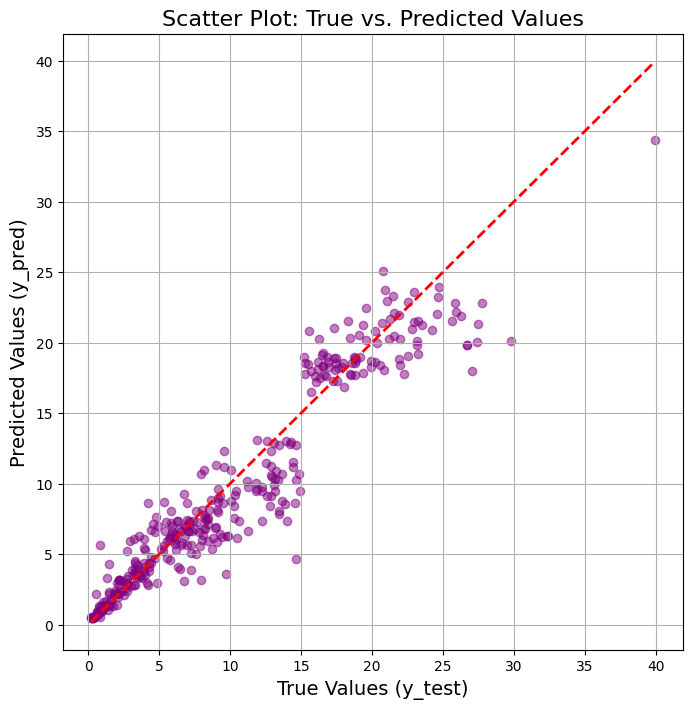

In [182]:
plt.figure(figsize=(8, 8))
plt.scatter(y_test['occupancy rate'], y_pred, alpha=0.5, color="purple")
plt.plot([y_test['occupancy rate'].min(), y_test['occupancy rate'].max()], [y_test['occupancy rate'].min(), y_test['occupancy rate'].max()], "r--", lw=2)  # Perfect prediction line
plt.title("Scatter Plot: True vs. Predicted Values", fontsize=16)
plt.xlabel("True Values (y_test)", fontsize=14)
plt.ylabel("Predicted Values (y_pred)", fontsize=14)
plt.grid(True)
plt.show()

In [179]:
y_pred_final = pd.DataFrame()
y_pred_final['occupancy rate'] = y_pred
y_pred_final['flow rate'] = y_pred_2

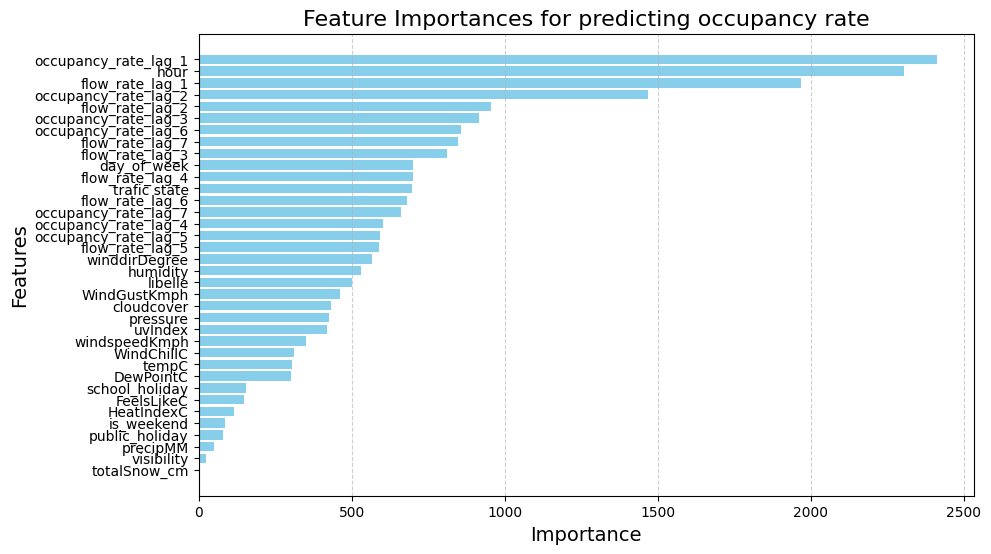

In [186]:
# Get feature importances
feature_importances = final_model_2.feature_importances_

# Get feature names from x_train
feature_names = x_train.columns

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": feature_importances
})

# Sort by importance
importance_df = importance_df.sort_values(by="Importance", ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df["Feature"], importance_df["Importance"], color="skyblue")
plt.gca().invert_yaxis()  # Invert y-axis to show the most important features at the top
plt.title("Feature Importances for predicting occupancy rate", fontsize=16)
plt.xlabel("Importance", fontsize=14)
plt.ylabel("Features", fontsize=14)
plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.show()

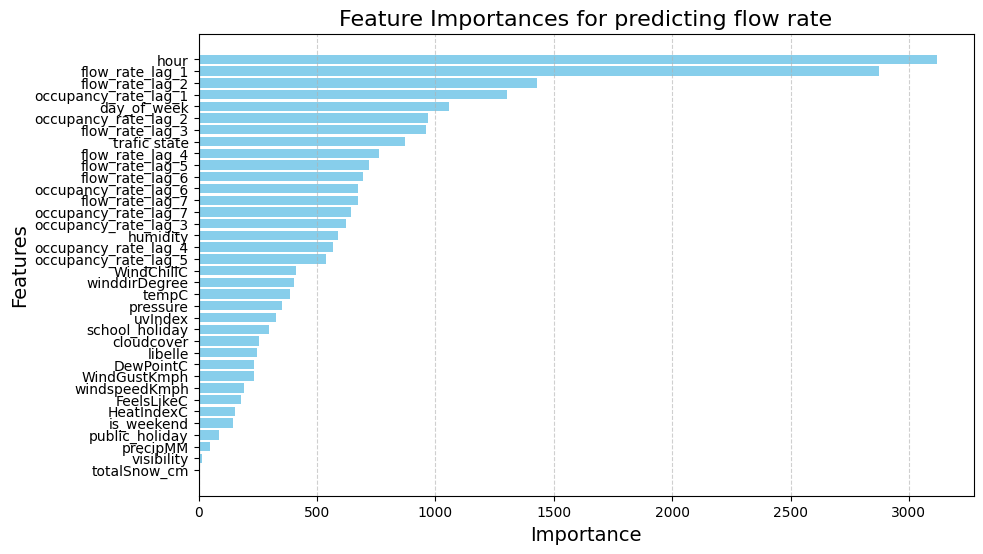

In [187]:
# Get feature importances
feature_importances = final_model.feature_importances_

# Get feature names from x_train
feature_names = x_train.columns

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": feature_importances
})

# Sort by importance
importance_df = importance_df.sort_values(by="Importance", ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df["Feature"], importance_df["Importance"], color="skyblue")
plt.gca().invert_yaxis()  # Invert y-axis to show the most important features at the top
plt.title("Feature Importances for predicting flow rate", fontsize=16)
plt.xlabel("Importance", fontsize=14)
plt.ylabel("Features", fontsize=14)
plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.show()

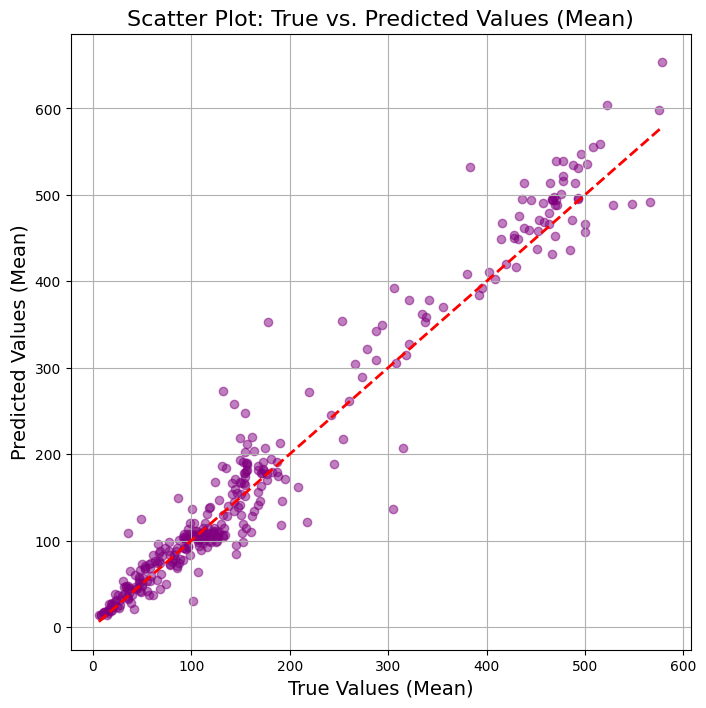

In [189]:
# Aggregate the two variables by mean (or other function)
y_test_mean = y_test.mean(axis=1)
y_pred_mean = y_pred_final.mean(axis=1)

plt.figure(figsize=(8, 8))
plt.scatter(y_test_mean, y_pred_mean, alpha=0.5, color="purple")
plt.plot([y_test_mean.min(), y_test_mean.max()], 
         [y_test_mean.min(), y_test_mean.max()], 
         "r--", lw=2)  # Perfect prediction line
plt.title("Scatter Plot: True vs. Predicted Values (Mean)", fontsize=16)
plt.xlabel("True Values (Mean)", fontsize=14)
plt.ylabel("Predicted Values (Mean)", fontsize=14)
plt.grid(True)
plt.show()
